### Code below finds Chessboard corners and draws them


In [99]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib qt


### We first find distortion coefficient for camera using chessboard images and store these in a pickle file for later use

In [100]:
nx = 9 #no of points per row
ny = 6 #no of points per column

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')



In [101]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### using object and image points above, find and store distortion coefficients

In [102]:

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])


# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

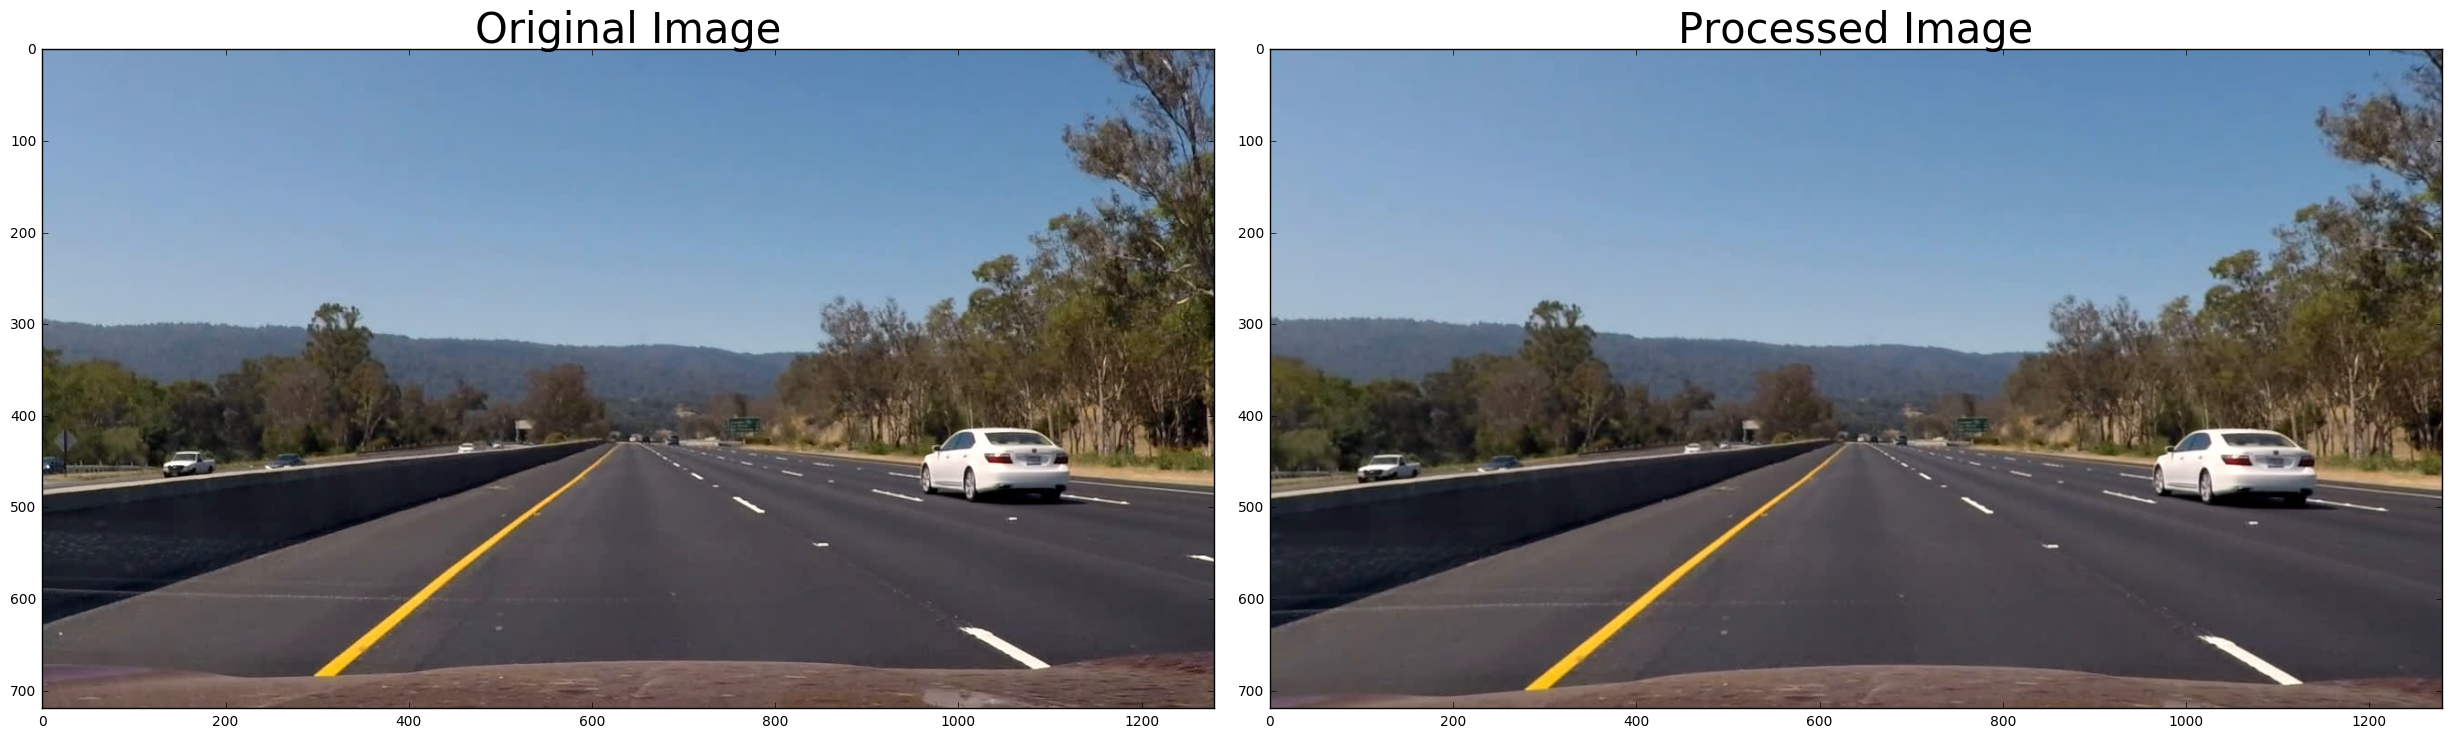

In [103]:
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# visualize two images - left original and right processed image
def visualize(src, dst, bgr_type = False, dst_is_gray=False):
    if bgr_type:
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(src)
    ax1.set_title('Original Image', fontsize=30)
    if dst_is_gray:
        ax2.imshow(dst, cmap='gray')
    else:
        ax2.imshow(dst)
    ax2.set_title('Processed Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img, mtx, dist)
    cv2.imwrite('output_images/undist_'+fname[12:],dst)
    #just plot test1.jpg image
    if fname[12:] == 'test7.jpg':
        visualize(img, dst, bgr_type=True)


### With distortion coefficients calculated, now move to applying thresholding

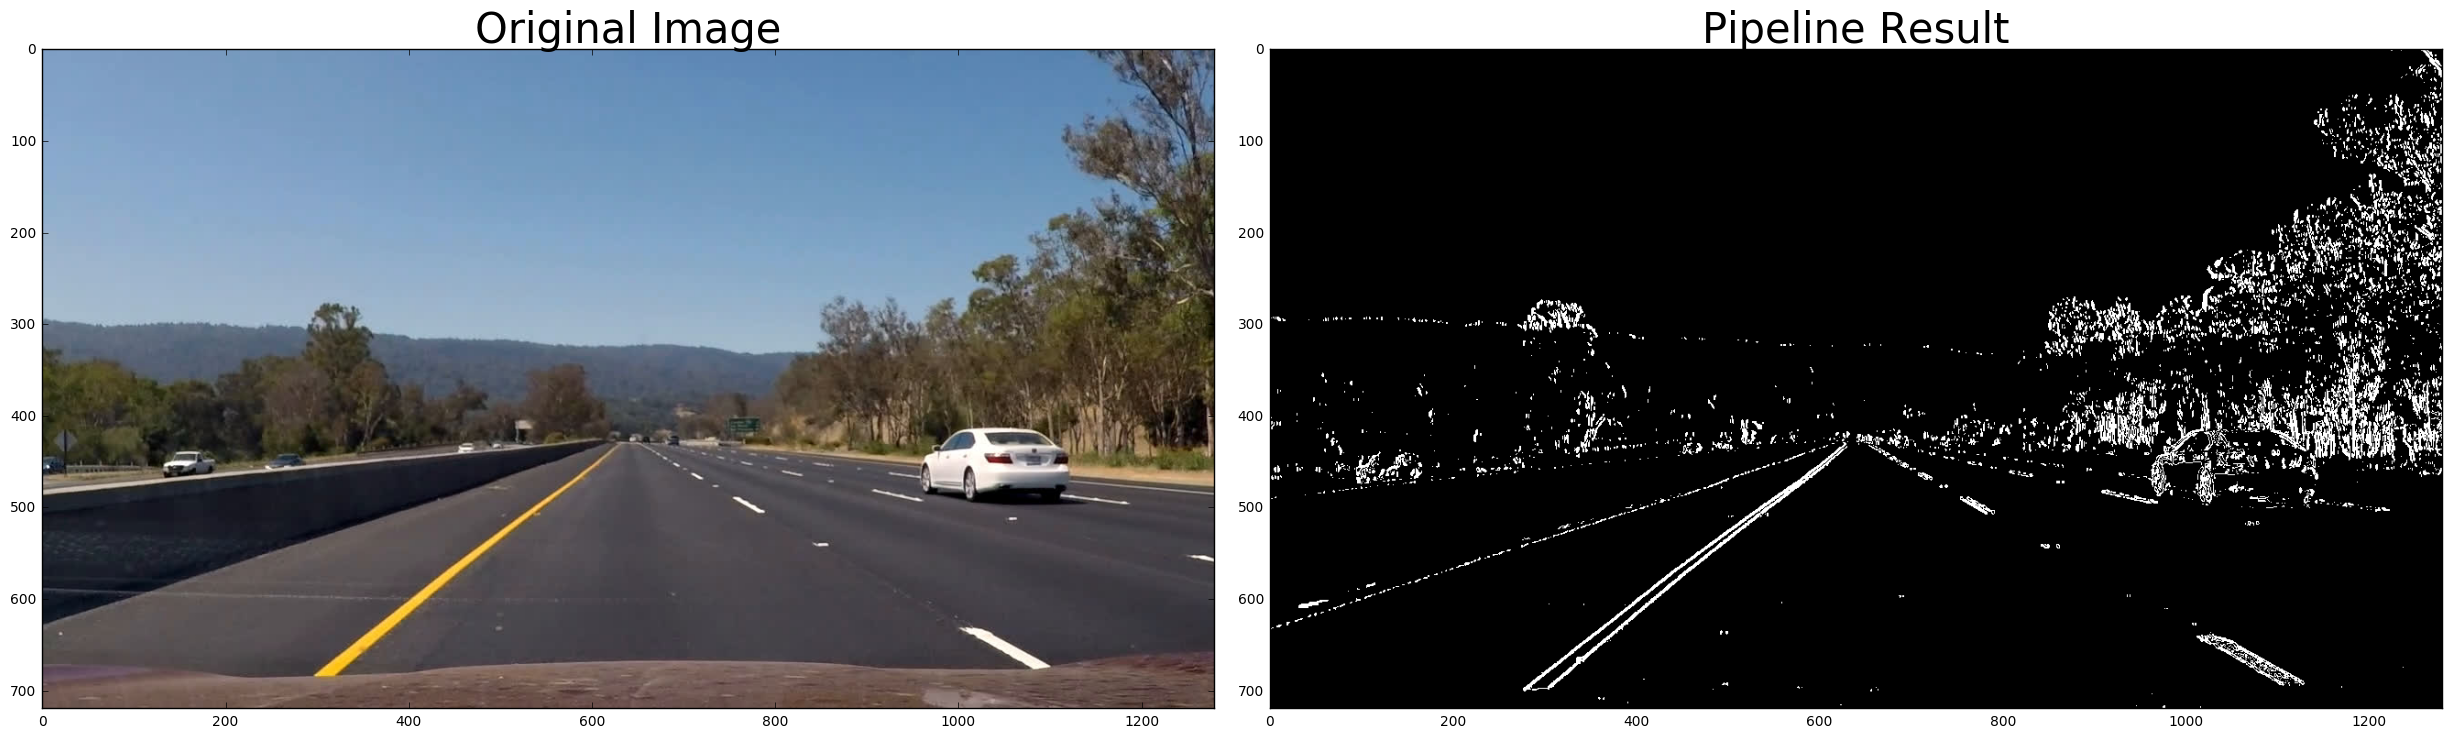

In [104]:

# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# this pipeline takes the original image and
# applies a combined gradient and S channel thresholding
# imgae is supposed be read with imread giving RGB colors
def threshold(img, sobel_kernel=3, s_thresh=(170, 220), mag_thresh=(20, 100)):
    img = np.copy(img)
    
    #Do Sobel_mag
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # removed sobely after trial and error
    gradmag = np.sqrt(sobelx**2 + sobely**2*0)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    grad_binary = np.zeros_like(gradmag)
    grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    #Do S channel Thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    #Combine two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1)] = 1

    return combined_binary


# test this part of pipeline i.e. undistort and Threshold

img = mpimg.imread('test_images/test7.jpg')
undist = undistort(img, mtx, dist)
result = threshold(undist)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

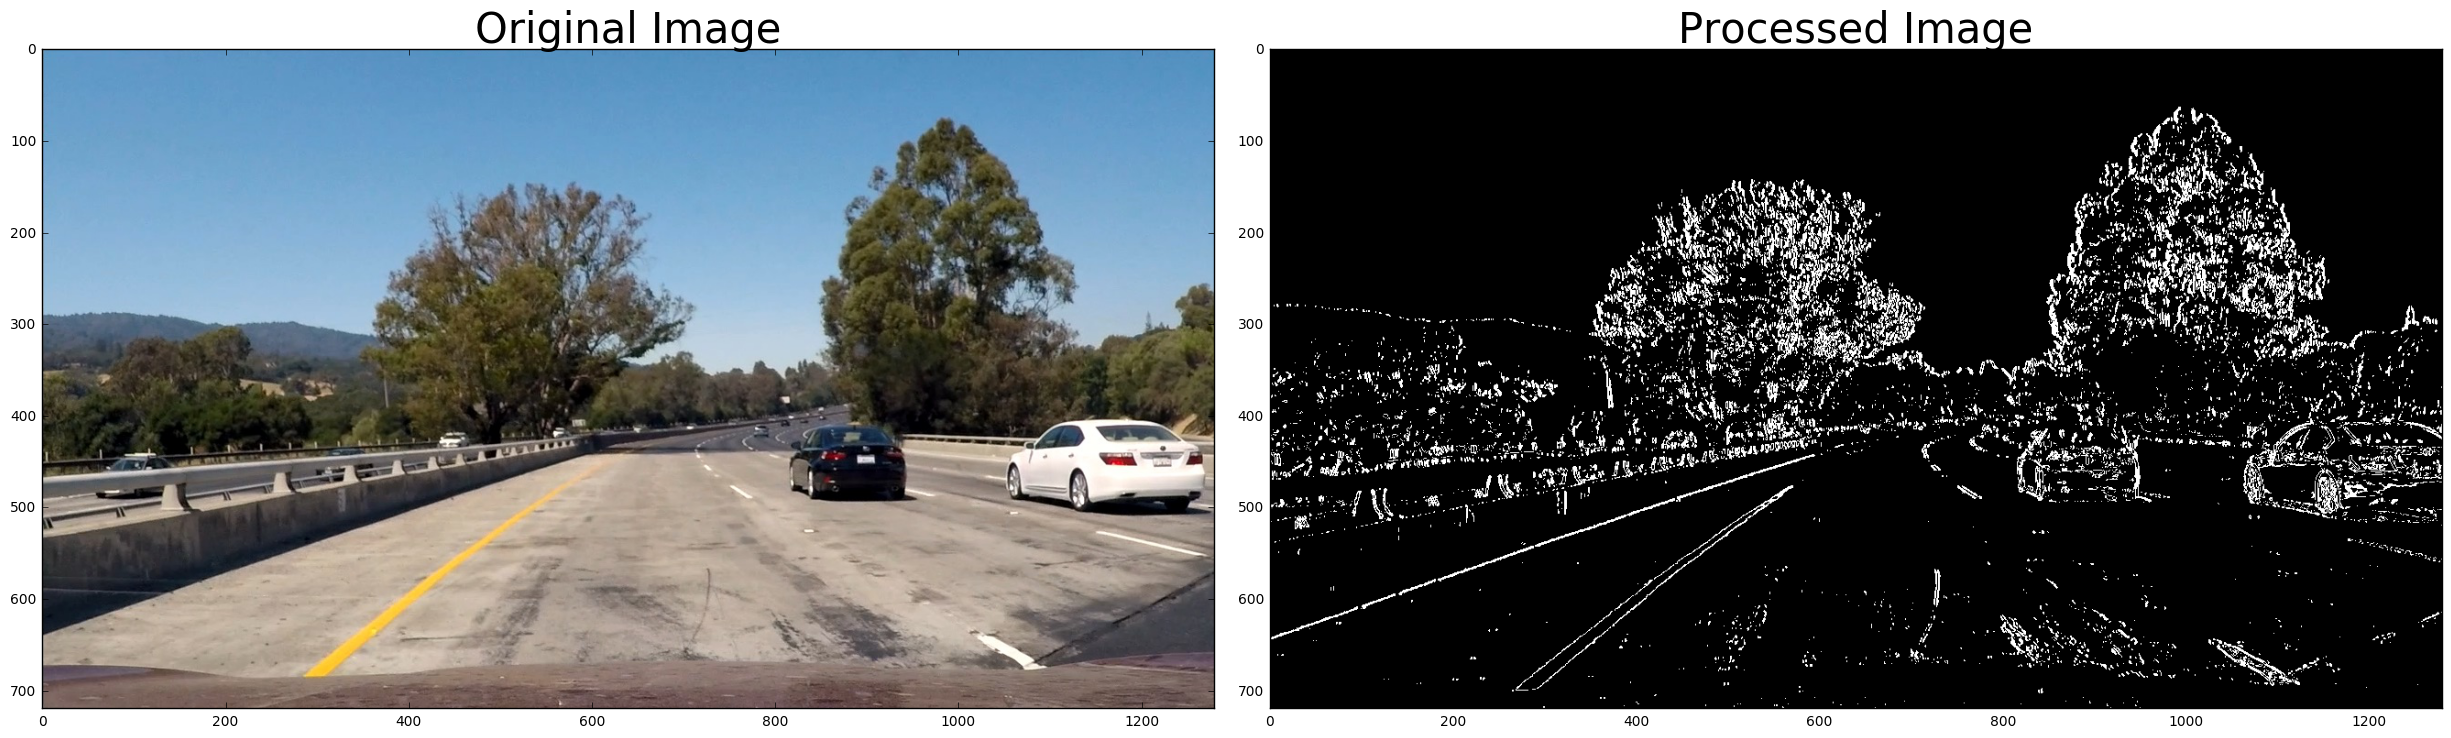

In [108]:
# process all test images and store output
# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img, mtx, dist)
    result = threshold(undist)
    mpimg.imsave('output_images/undist_thresh_'+fname[12:],result, cmap='gray')
    if fname[12:] == 'test1.jpg':
        visualize(img, result, bgr_type = False, dst_is_gray=True)


### now we do perspective transform

(720, 1280, 3)


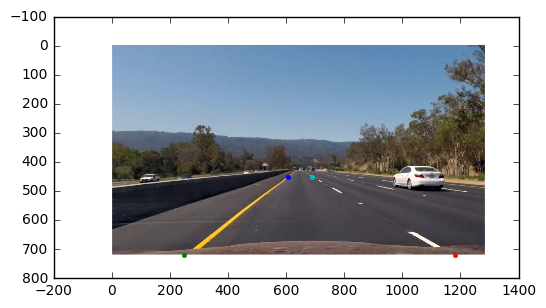

In [109]:
%matplotlib inline
img = mpimg.imread('output_images/undist_test7.jpg')
print (img.shape)
plt.imshow(img)

#plt.plot(625,450,'.') # top left
#plt.plot(243, 719, '.') # bottom left
#plt.plot(1160, 719, '.') # bottom right
#plt.plot(725, 450, '.') # top right

plt.plot(606,450,'.') # top left
plt.plot(250, 719, '.') # bottom left
plt.plot(1182, 719, '.') # bottom right
plt.plot(690, 450, '.') # top right

# Trapiziod for image test7 is given above. THis is used to create the perspective tarnsform

# 4 points on the lane lines that will appear straight in topdown view
src = np.float32(
    [[606, 450],
     [250, 719],
     [1182,719],
     [690, 450]
    ])
#Cooridate of above 4 points that should appear in topdown view
dst = np.float32(
    [[290,0],
     [290, 719],
     [990,719],
     [990,0]
    ])

# calculate perspective transform
M = cv2.getPerspectiveTransform(src, dst)

#calculate inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst, src)

M_pickle = {}
M_pickle["M"] = M
M_pickle["Minv"] = Minv
pickle.dump( M_pickle, open( "M_pickle.p", "wb" ) )


### See the result of Perspective transform on the image used for creating the transform Matrix

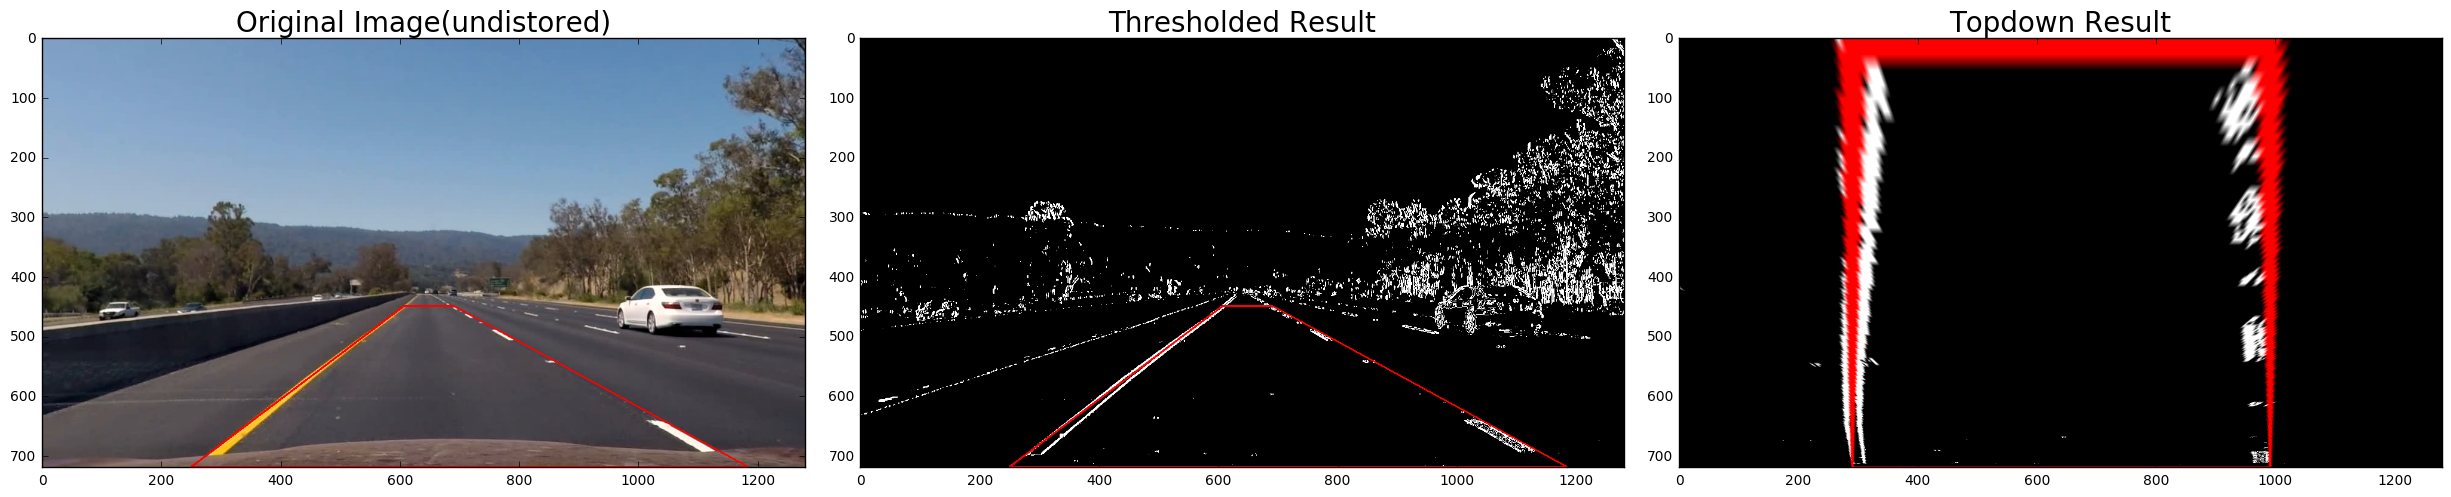

In [110]:
# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# readd in saved M and Minv
M_pickle = pickle.load( open( "M_pickle.p", "rb" ) )
M = M_pickle["M"]
Minv = M_pickle["Minv"]

img = mpimg.imread('test_images/test7.jpg')



undist = undistort(img, mtx, dist)
thresh = threshold(undist)
# convert gray sclae to RGB
thresh_3 = np.dstack((thresh, thresh, thresh))*255
cv2.line(thresh_3,tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=2 )
cv2.line(thresh_3,tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=2 )
cv2.line(thresh_3,tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=2 )
cv2.line(thresh_3,tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=2 )
img_size = (thresh.shape[1], thresh.shape[0])

warped = cv2.warpPerspective(thresh_3, M, img_size)

cv2.line(undist,tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=2 )
cv2.line(undist,tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=2 )
cv2.line(undist,tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=2 )
cv2.line(undist,tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=2 )


#draw line of undistort


# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image(undistored)', fontsize=20)
ax2.imshow(thresh_3)
ax2.set_title('Thresholded Result', fontsize=20)
ax3.imshow(warped)
ax3.set_title('Topdown Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Process all images store the result of pipeline undistort->threshold->Perspective

In [111]:
# process all test images and store outputafter warping
# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img, mtx, dist)
    thresh = threshold(undist)
    thresh_3 = np.dstack((thresh, thresh, thresh))*255
    cv2.line(thresh_3,tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=1 )
    cv2.line(thresh_3,tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=1 )
    cv2.line(thresh_3,tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=1 )
    cv2.line(thresh_3,tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=1 )
    img_size = (thresh.shape[1], thresh.shape[0])
    warped = cv2.warpPerspective(thresh_3, M, img_size)
    mpimg.imsave('output_images/warped_'+fname[12:],warped)


### Now move on to Locating lines

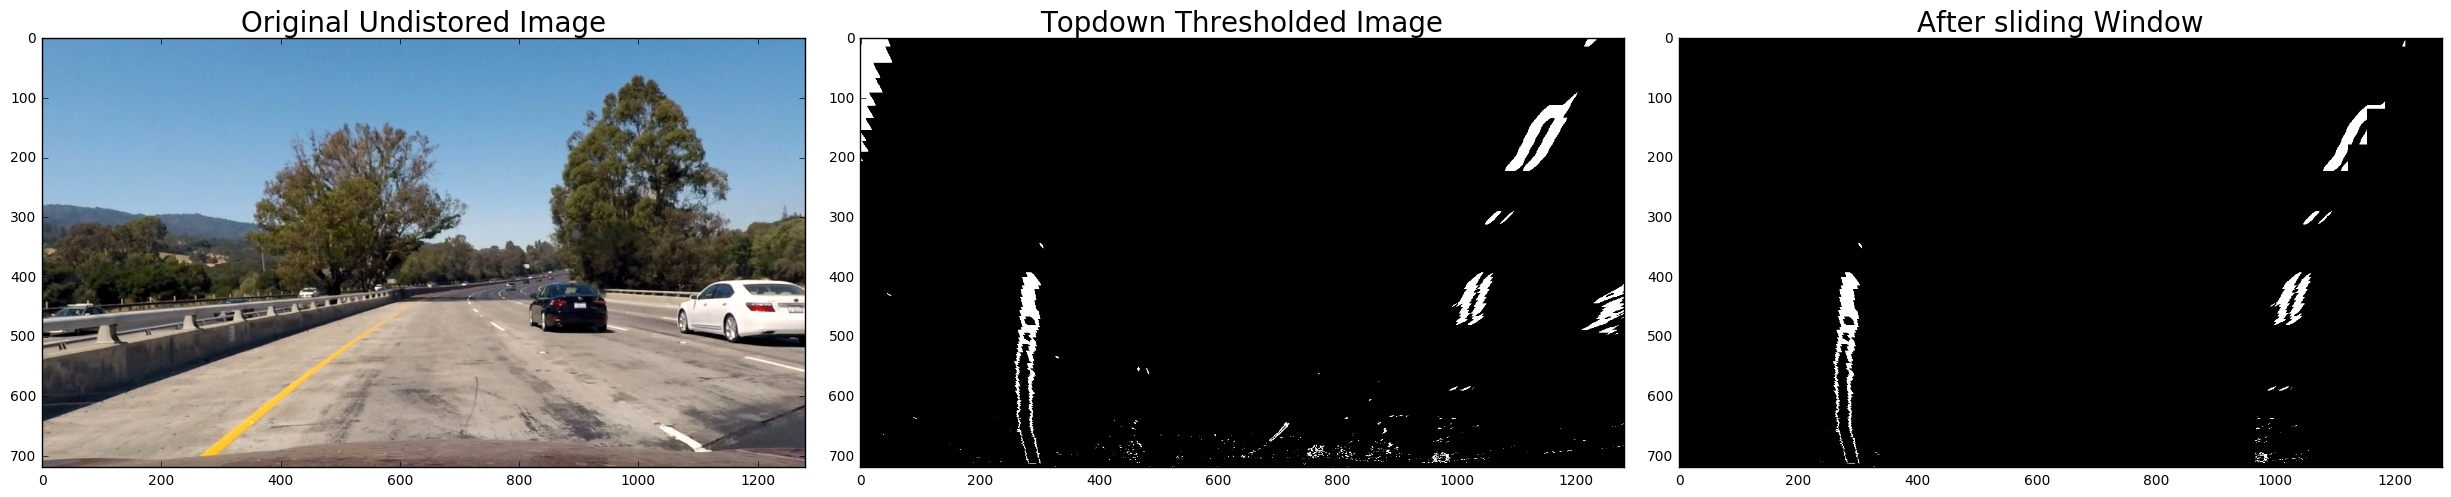

In [113]:
def initial_lane_centers(h):
    midp = np.int(h.shape[0]/2)
    lc = np.argmax(h[:midp])
    rc = np.argmax(h[midp:])+midp
    return (lc, rc)


def sliding_windows(src, dst, mid, win_size=50, win_height=60):
    for row in range(src.shape[0],0,-win_height):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[max(0,row-win_height):row, st:end] = src[max(0,row-win_height):row, st:end]
        ones = np.where(src[max(0,row-win_height):row, st:end] == 1)
        # ones will be a tuple where first element i.e. ones[0] is the y indices of non zero elments and 2nd element i.e. ones[1] is
        # x indicies of non zero values. We will extract only the 2nd element and take an average to findd the 
        # x center of slice
        if len(ones[1]):
            mid = np.int(np.mean(ones[1])+st)
            


img = mpimg.imread('test_images/test1.jpg')
undist = undistort(img, mtx, dist)
thresh = threshold(undist)
img_size = (thresh.shape[1], thresh.shape[0])
warped = cv2.warpPerspective(thresh, M, img_size)
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
lc, rc = initial_lane_centers(histogram)
lines = np.zeros_like(warped)
sliding_windows(warped, lines, lc)
sliding_windows(warped, lines, rc)



# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Undistored Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Topdown Thresholded Image', fontsize=20)
ax3.imshow(lines, cmap='gray')
ax3.set_title('After sliding Window', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Process all images store the result of pipeline undistort->threshold->Perspective->isolate Lines

In [114]:
# process all test images and store outputafter warping and lane identification
# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and process each image
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img, mtx, dist)
    thresh = threshold(undist)
    img_size = (thresh.shape[1], thresh.shape[0])
    warped = cv2.warpPerspective(thresh, M, img_size)
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    lc, rc = initial_lane_centers(histogram)
    lines = np.zeros_like(warped)
    sliding_windows(warped, lines, lc)
    sliding_windows(warped, lines, rc)    
    mpimg.imsave('output_images/only_lanes_'+fname[12:],lines, cmap='gray')

### Next step is to fit the Right and Left Lines

In [115]:
def fit_poly(lane_img, plot_fit=False):
    # mid point on x axis to divide the image into two halfs
    midx = np.int(lane_img.shape[1]/2)
    yvals = np.linspace(0,img.shape[0]-1,img.shape[1])
    left_ln_pts = np.where(lane_img[:,:midx]==1) #returns the tuple with first element all the y and 2nd all the x
    right_ln_pts = np.where(lane_img[:,midx:]==1)
    left_fit = np.polyfit(left_ln_pts[0], left_ln_pts[1], 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_ln_pts[0], right_ln_pts[1]+midx, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    #now visualize the fit
    if plot_fit:
        plt.plot(left_ln_pts[1], left_ln_pts[0], 'o', color='red')
        plt.plot(right_ln_pts[1]+midx, right_ln_pts[0], 'o', color='red')
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, yvals, color='green', linewidth=3)
        plt.plot(right_fitx, yvals, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
    #calculate Curvature in pixels
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meteres per pixel in x dimension
    y_eval = np.max(yvals)
    left_fit_cr = np.polyfit(left_ln_pts[0]*ym_per_pix, left_ln_pts[1]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_ln_pts[0]*ym_per_pix, (right_ln_pts[1]+midx)*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return (left_fit, left_curverad, right_fit, right_curverad)

5758.33736451 m 43055.2116784 m


(array([ -3.75705164e-05,   1.23813903e-03,   3.05223911e+02]),
 5758.3373645094762,
 array([  4.90728553e-06,   4.03144612e-02,   9.45914668e+02]),
 43055.211678428241)

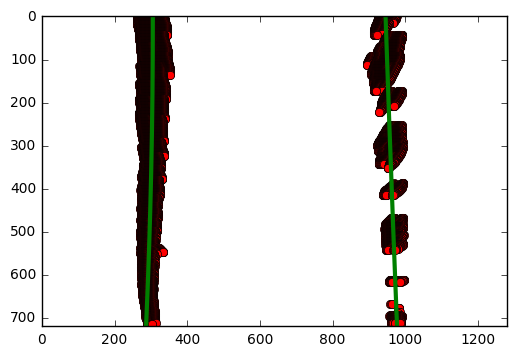

In [116]:
fit_poly(lines, True)

### Final Pipeline: Undistort -> threshold -> perspective -> Isolate lines -> fit lane lines -> Reverse Perspective with Lane and other data superimposed

In [117]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #no of history data
        self.n = 5
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients from last n iterations
        self.last_n_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None



def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# this pipeline takes the original image and
# applies a combined gradient and S channel thresholding
# imgae is supposed be read with imread giving RGB colors
def threshold(img, sobel_kernel=3, s_thresh=(170, 220), mag_thresh=(20, 100)):
    img = np.copy(img)
    
    #Do Sobel_mag
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # removed sobely after trial and error
    gradmag = np.sqrt(sobelx**2 + sobely**2*0)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    grad_binary = np.zeros_like(gradmag)
    grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    #Do S channel Thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    #Combine two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1)] = 1

    return combined_binary

def apply_perspective(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped


def initial_lane_centers(h):
    midp = np.int(h.shape[0]/2)
    lc = np.argmax(h[:midp])
    rc = np.argmax(h[midp:])+midp
    return (lc, rc)

# original sliding window which uses single row as window height
def sliding_windows_one_row(src, dst, mid, win_size=25):
    for row in range(src.shape[0]-1,-1,-1):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[row,st:end] = src[row,st:end]
        ones = np.where(src[row,st:end] == 1)
        if len(ones[0]):
            mid = np.int(np.mean(ones)+st)

def sliding_windows(src, dst, mid, win_size=50, win_height=60):
    for row in range(src.shape[0],0,-win_height):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[max(0,row-win_height):row, st:end] = src[max(0,row-win_height):row, st:end]
        ones = np.where(src[max(0,row-win_height):row, st:end] == 1)
        # ones will be a tuple where first element i.e. ones[0] is the y indices of non zero elments and 2nd element i.e. ones[1] is
        # x indicies of non zero values. We will extract only the 2nd element and take an average to findd the 
        # x center of slice
        if len(ones[1]):
            mid = np.int(np.mean(ones[1])+st)
            
            
def isolate_lanes(img, left_line, right_line, reinitiate=True):
    warped = np.copy(img)
    if reinitiate:
        histogram = np.sum(warped[warped.shape[0]/3:,:], axis=0)
        lc, rc = initial_lane_centers(histogram)
    else:
        yval = warped.shape[0]-1
        lc = left_line.best_fit[0]*yval**2+left_line.best_fit[1]*yval+left_line.best_fit[2]
        rc = right_line.best_fit[0]*yval**2+right_line.best_fit[1]*yval+right_line.best_fit[2]
        
    lines = np.zeros_like(warped)
    sliding_windows(warped, lines, lc)
    sliding_windows(warped, lines, rc)
    return lines

def detect_line(points, is_left_ln):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    # mid point on x-axis
    midx = np.int(points.shape[1]/2)
    # values from 0 to 719 - the nmber of pixels of the height of image
    yvals = np.linspace(0, points.shape[0]-1,points.shape[0])
    ln_pts = np.where(points==1) #returns the tuple with first element all the y and 2nd all the x
    # fit a degree 2 polynomial
    fit = np.polyfit(ln_pts[0], ln_pts[1], 2)
    fitx = fit[0]*yvals**2 + fit[1]*yvals + fit[2]
    
    #find error in estimation and coffcient of determination
    x_est = fit[0]*ln_pts[0]**2 + fit[1]*ln_pts[0] + fit[2]
    fit_coeff = 1 - np.sum((x_est - ln_pts[1])**2) / np.sum((ln_pts[1] - np.mean(ln_pts[1]))**2)
    
    # curvature in meters
    fit_cr = np.polyfit(ln_pts[0]*ym_per_pix, ln_pts[1]*xm_per_pix, 2)
    y_eval = np.max(yvals)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])
    
    # offset of vehicle from center of lane
    if is_left_ln:
        _base_pos = 350 - abs(fitx[-1] - midx)  #350 is half of lane width in pixels
    else:
        _base_pos = abs(fitx[-1] - midx) - 350 
    #convert pixels to meters    
    _base_pos = _base_pos * xm_per_pix

    return (fit_coeff, fitx, fit, curverad, _base_pos, ln_pts[1], ln_pts[0])

    

def fit_poly(lane_img, left_line, right_line, video_clip=False):
    if left_line == None or right_line == None:
        print("Lines can't be null. Check code")
        
    global bad_frames_cnt


    # mid point on x axis to divide the image into two halfs
    midx = np.int(lane_img.shape[1]/2)
    
    #retain only left half pixels in image
    left_lane_img = np.copy(lane_img)
    left_lane_img[:,midx:] = 0

    #retain only right half pixels in image
    right_lane_img = np.copy(lane_img)
    right_lane_img[:, :midx] = 0
    
    #process each image to collect the data
    l_fit_coeff, l_fitx, l_fit, l_curverad, l_base_pos, l_x, l_y = detect_line(left_lane_img, is_left_ln=True)
    r_fit_coeff, r_fitx, r_fit, r_curverad, r_base_pos, r_x, r_y = detect_line(right_lane_img, is_left_ln=False)
    #print(l_fit_coeff, r_fit_coeff)
        
    #now we should do sanity check of two detections and then decide to store the lines
    # check closeness of curvature - valid only if two line detections have high r2
    similar_curvature = abs(l_curverad - r_curverad) / (abs(l_curverad + r_curverad)/2) < 0.30

    # check if fitted lines are kind of parallel 
    # i.e. the separation at top and bottom are within 20%
    top_separation = r_fitx[0] - l_fitx[0]
    bottom_seaparation = r_fitx[-1] - l_fitx[-1]
    is_parallel =  abs(top_separation - bottom_seaparation) / (abs(top_separation + bottom_seaparation)/2) < 0.30
    
    #if both lines have high r2 and have similar curvature and kind of parallel
    if video_clip and similar_curvature and is_parallel and l_fit_coeff > 0.66 and r_fit_coeff > 0.66 :
        #lane found is good
        left_line.detected = True
        if len(left_line.recent_xfitted) != 0:
            left_line.recent_xfitted = np.vstack((l_fitx, left_line.recent_xfitted))[0:left_line.n+1]
        else:
            left_line.recent_xfitted = np.reshape(l_fitx,(1,-1))
        left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
        prev_l_fit = left_line.current_fit
        left_line.current_fit = l_fit
        if prev_l_fit != None:
            left_line.diffs = l_fit - prev_l_fit
        if len(left_line.last_n_fit) != 0: 
            left_line.last_n_fit = np.vstack((left_line.current_fit, left_line.last_n_fit))[0:left_line.n+1]
        else:
            left_line.last_n_fit = np.reshape(l_fit, (1,-1))
        left_line.best_fit = np.mean(left_line.last_n_fit, axis=0)
        left_line.radius_of_curvature = l_curverad
        left_line.line_base_pos = l_base_pos
        left_line.allx = l_x
        left_line.ally = l_y
        
        right_line.detected = True
        if len(right_line.recent_xfitted) != 0:
            right_line.recent_xfitted = np.vstack((r_fitx, right_line.recent_xfitted))[0:right_line.n+1]
        else:
            right_line.recent_xfitted = np.reshape(r_fitx,(1,-1))
        right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
        prev_r_fit = right_line.current_fit
        right_line.current_fit = r_fit
        if prev_r_fit != None:
            right_line.diffs = r_fit - prev_r_fit
        if len(right_line.last_n_fit) != 0: 
            right_line.last_n_fit = np.vstack((right_line.current_fit, right_line.last_n_fit))[0:right_line.n+1]
        else:
            right_line.last_n_fit = np.reshape(r_fit, (1,-1))
        right_line.best_fit = np.mean(right_line.last_n_fit, axis=0)
        right_line.radius_of_curvature = r_curverad
        right_line.line_base_pos = r_base_pos
        right_line.allx = r_x
        right_line.ally = r_y
        bad_frames_cnt = 0
        
    else:
        
        left_line.detected = False
        right_line.detected = False
        bad_frames_cnt = bad_frames_cnt+1
        
    if left_line.best_fit != None and right_line.best_fit != None and video_clip:
        return (left_line.best_fit, left_line.radius_of_curvature, right_line.best_fit, right_line.radius_of_curvature, 
                (left_line.line_base_pos+right_line.line_base_pos)/2, l_x, l_y, r_x, r_y)    
    else:
        return (l_fit, l_curverad, r_fit, r_curverad, 
                (l_base_pos+r_base_pos)/2, l_x, l_y, r_x, r_y)

def merge_lane(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    yvals = np.linspace(0,warp_zero.shape[0]-1,warp_zero.shape[0])
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def annotate(org_img, left_curvature, right_curvature, offset):
    img = np.copy(org_img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255,255,255)
    curvature_text = 'Curvature: Left = {:.2f} m and Right = {:.2f} m'.format(left_curvature, right_curvature)
    if offset < 0:
        offset_text = 'Lane Position: {:.2f} m left of center'.format(abs(offset))
    else:
        offset_text = 'Lane Position: {:.2f} m right of center'.format(abs(offset))
    
    cv2.putText(img, curvature_text, (10,30), font, 1, color, 2)
    cv2.putText(img, offset_text, (10,70), font, 1, color, 2)
    return img
    

def pipeline(img, mtx, dist, M, Minv, left_line, right_line, plot_result=False, video_clip=False):
    #undistort
    undist = undistort(img, mtx, dist)
    #threshold
    thresh = threshold(undist)
    # Do perspective Tranform
    warped = apply_perspective(thresh, M)
    #isolate lane lines and find curvature
    global bad_frames_cnt
        
    if video_clip and bad_frames_cnt < 7 and left_line.best_fit != None and right_line.best_fit != None:
        warped_lanes = isolate_lanes(warped, left_line, right_line, reinitiate=False)
    else:
        warped_lanes = isolate_lanes(warped, left_line, right_line, reinitiate=True)
        bad_frames_cnt = 0
        
    #do fit and find curvature
    left_fit, left_curverad, right_fit, right_curverad, offset, l_x, l_y, r_x, r_y = \
        fit_poly(warped_lanes, left_line, right_line, video_clip)
    #draw polyfill on warped image and reverse the perspective to original
    lane_fitted_img = merge_lane(undist, warped, Minv, left_fit, right_fit)
    #annotate
    annotated_img = annotate(lane_fitted_img, left_curverad, right_curverad, offset)

    
    #plot result
    if plot_result:
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undist)
        ax1.set_title('Original undistored Image', fontsize=10)
        ax2.imshow(thresh, cmap='gray')
        ax2.set_title('Threshold Image', fontsize=10)
        ax3.imshow(warped, cmap='gray')
        ax3.set_title('Warped', fontsize=10)
        ax4.imshow(warped_lanes, cmap='gray')
        ax4.set_title('Warped Lanes only', fontsize=10)
        
        ax5.imshow(annotated_img)
        ax5.set_title('Lane Fitted', fontsize=10)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

        f2, (ax6) = plt.subplots(1, 1, figsize=(24, 9))
        f2.tight_layout()
        ax6.set_title('Poly Fit', fontsize=10)
        yvals = np.linspace(0, img.shape[0]-1,img.shape[0])
        ax6.scatter(l_x, l_y, c='red', alpha=0.1)
        ax6.scatter(r_x, r_y, c='blue', alpha=0.1)
        ax6.set_xlim(0, 1280)
        ax6.set_ylim(0, 720)
        l_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
        r_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
        
        ax6.plot(l_fitx, yvals, color='green', linewidth=6)
        ax6.plot(r_fitx, yvals, color='green', linewidth=6)
        ax6.invert_yaxis() # to visualize as we do the images

        

    #return lane fitted and annotated image
    return annotated_img
    
    




### Run full pipeline on all images

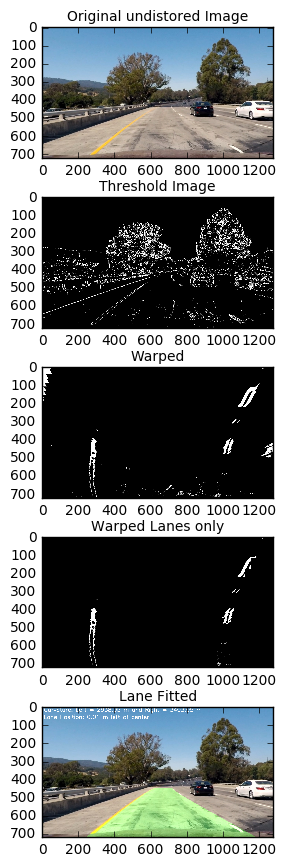

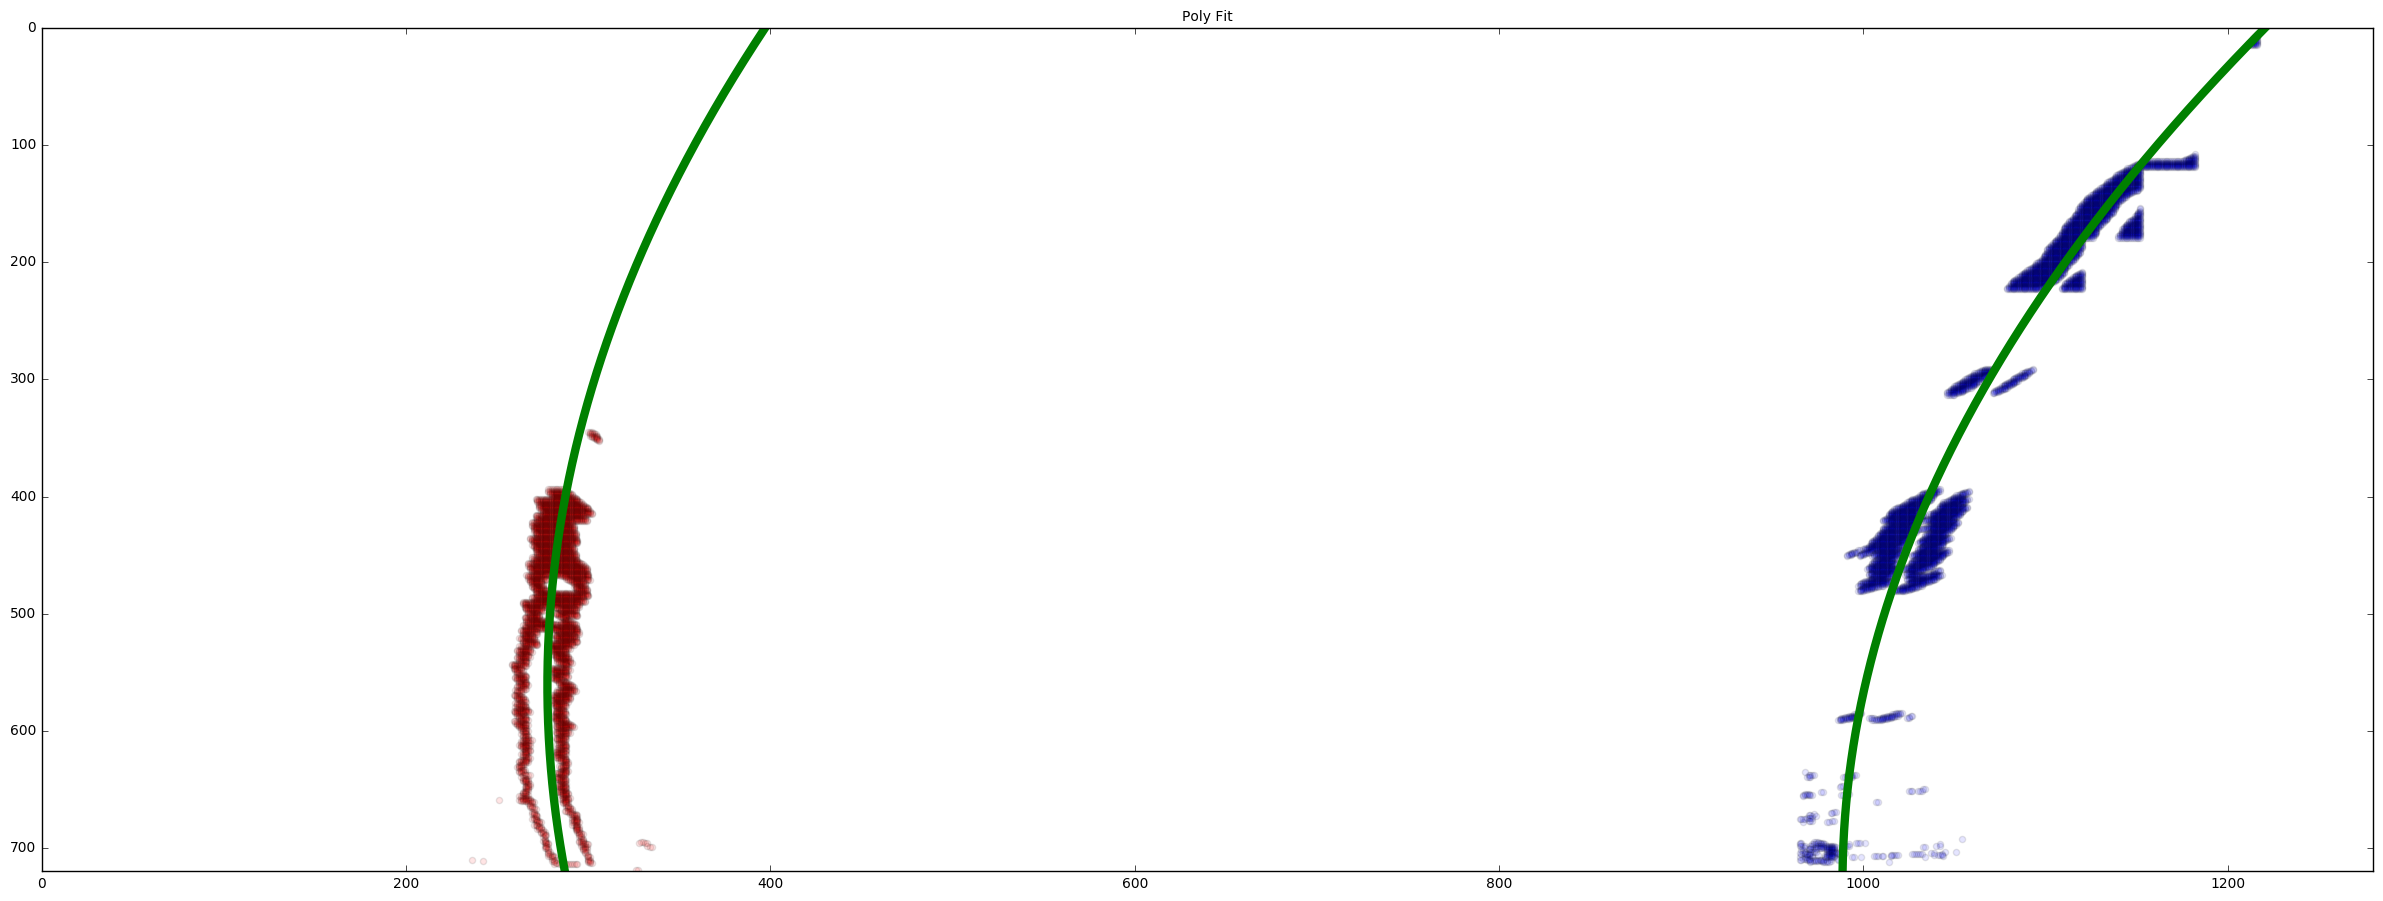

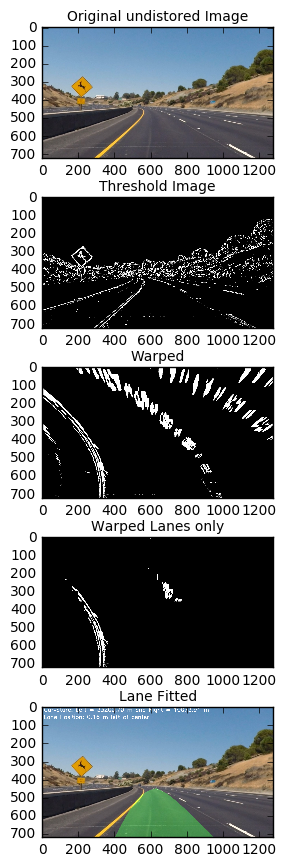

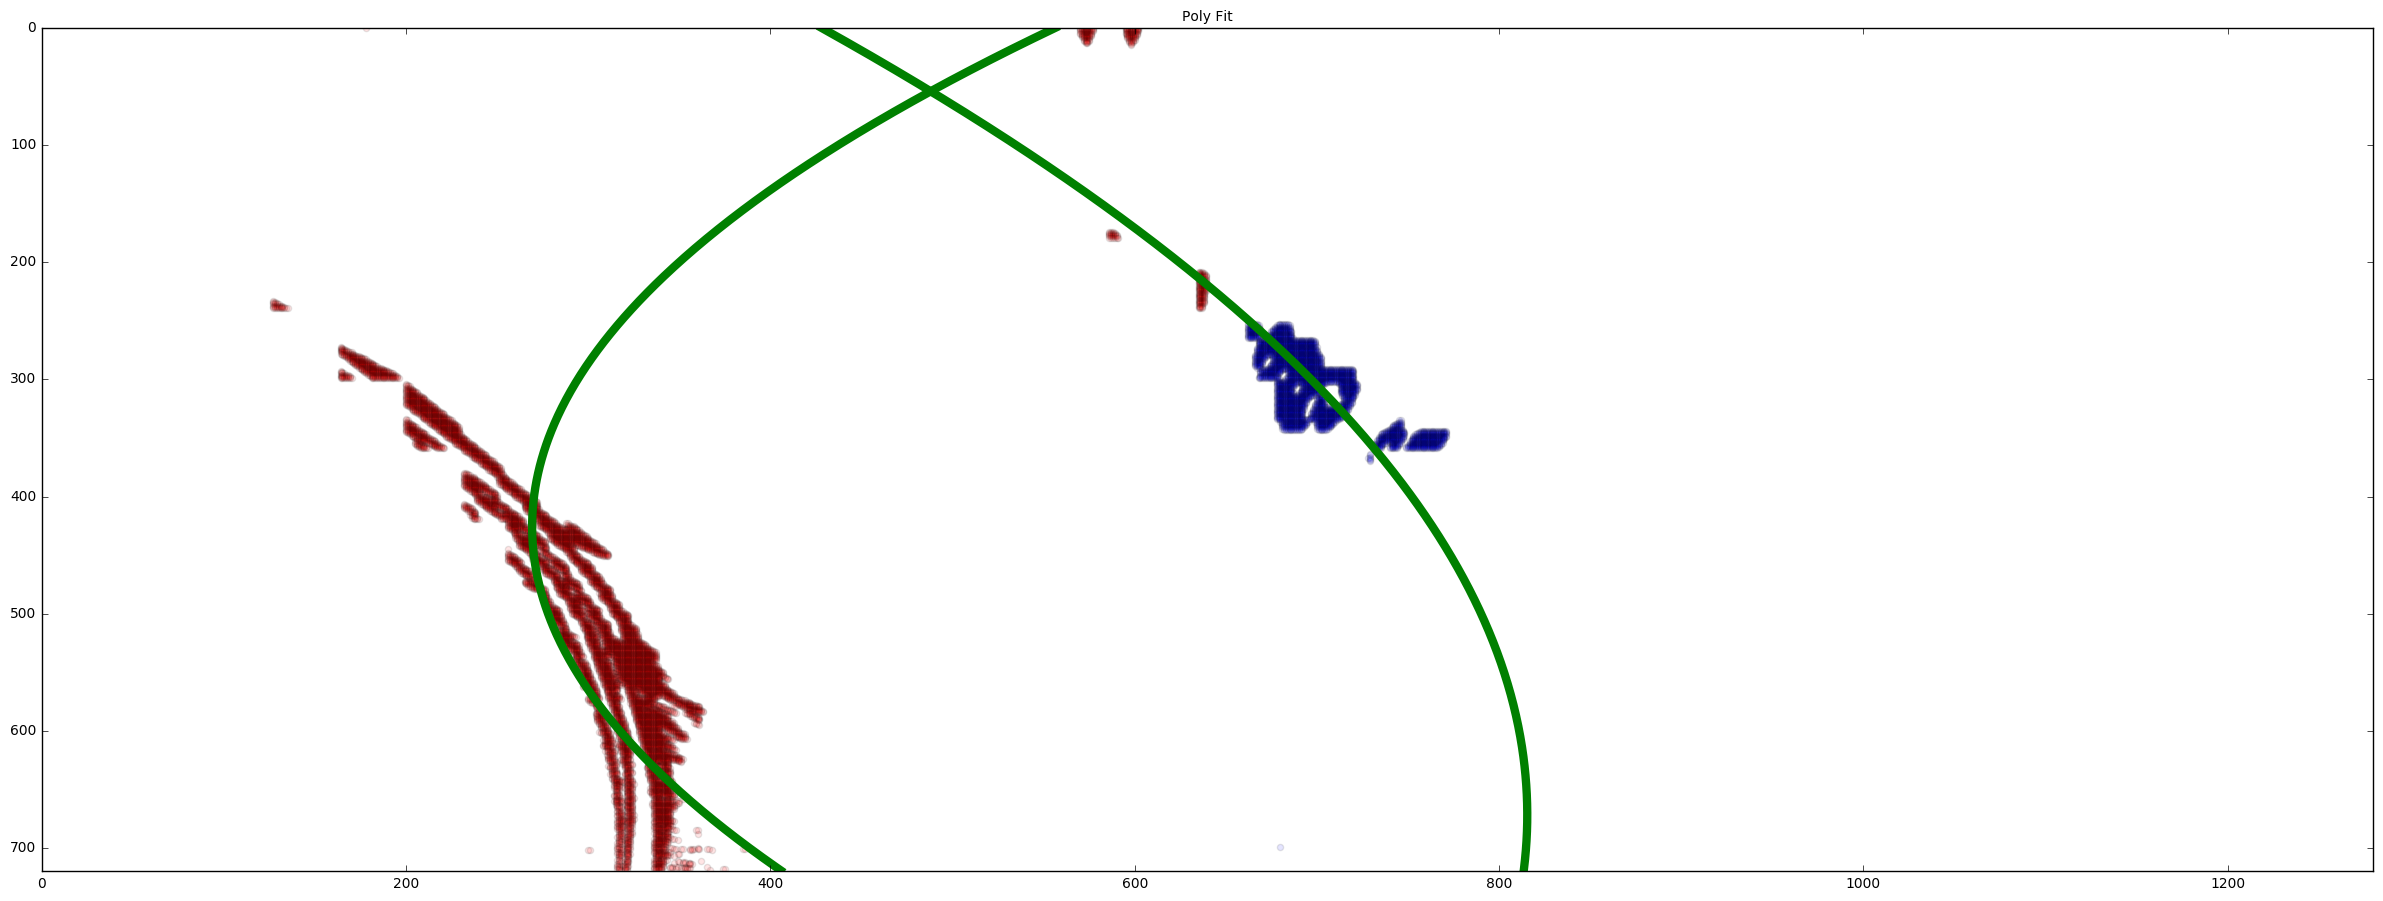

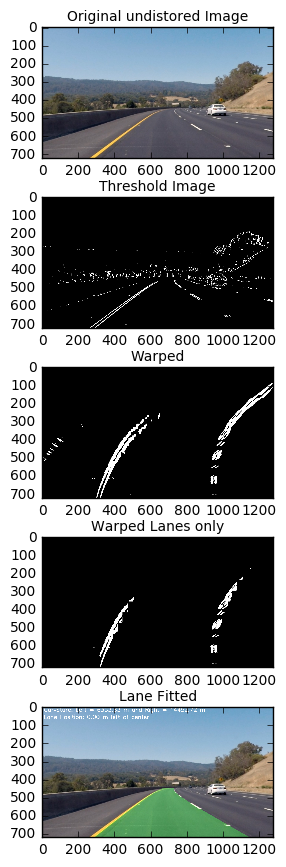

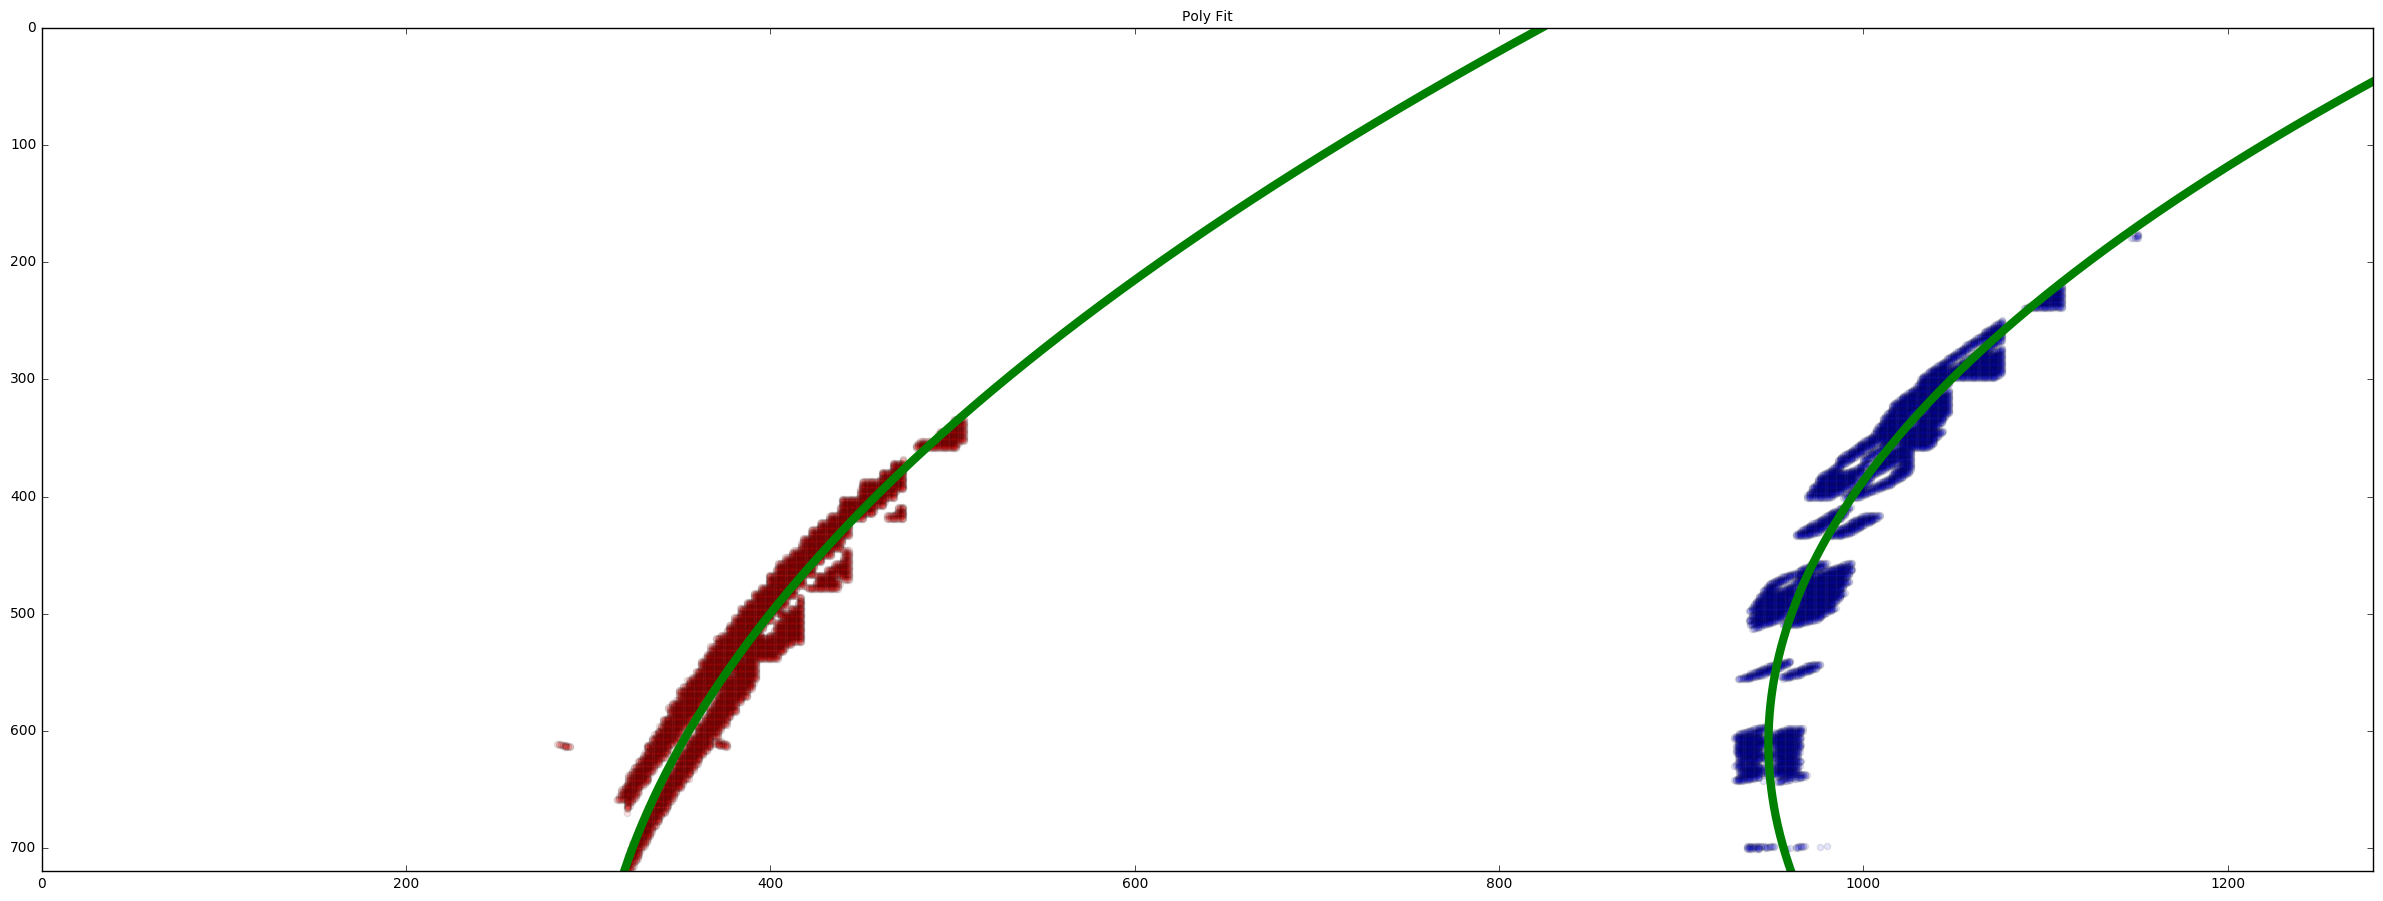

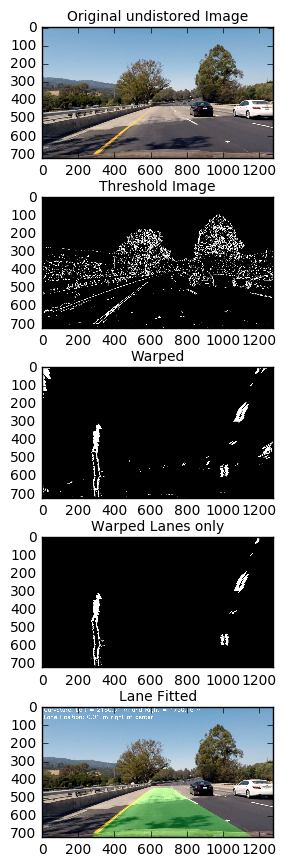

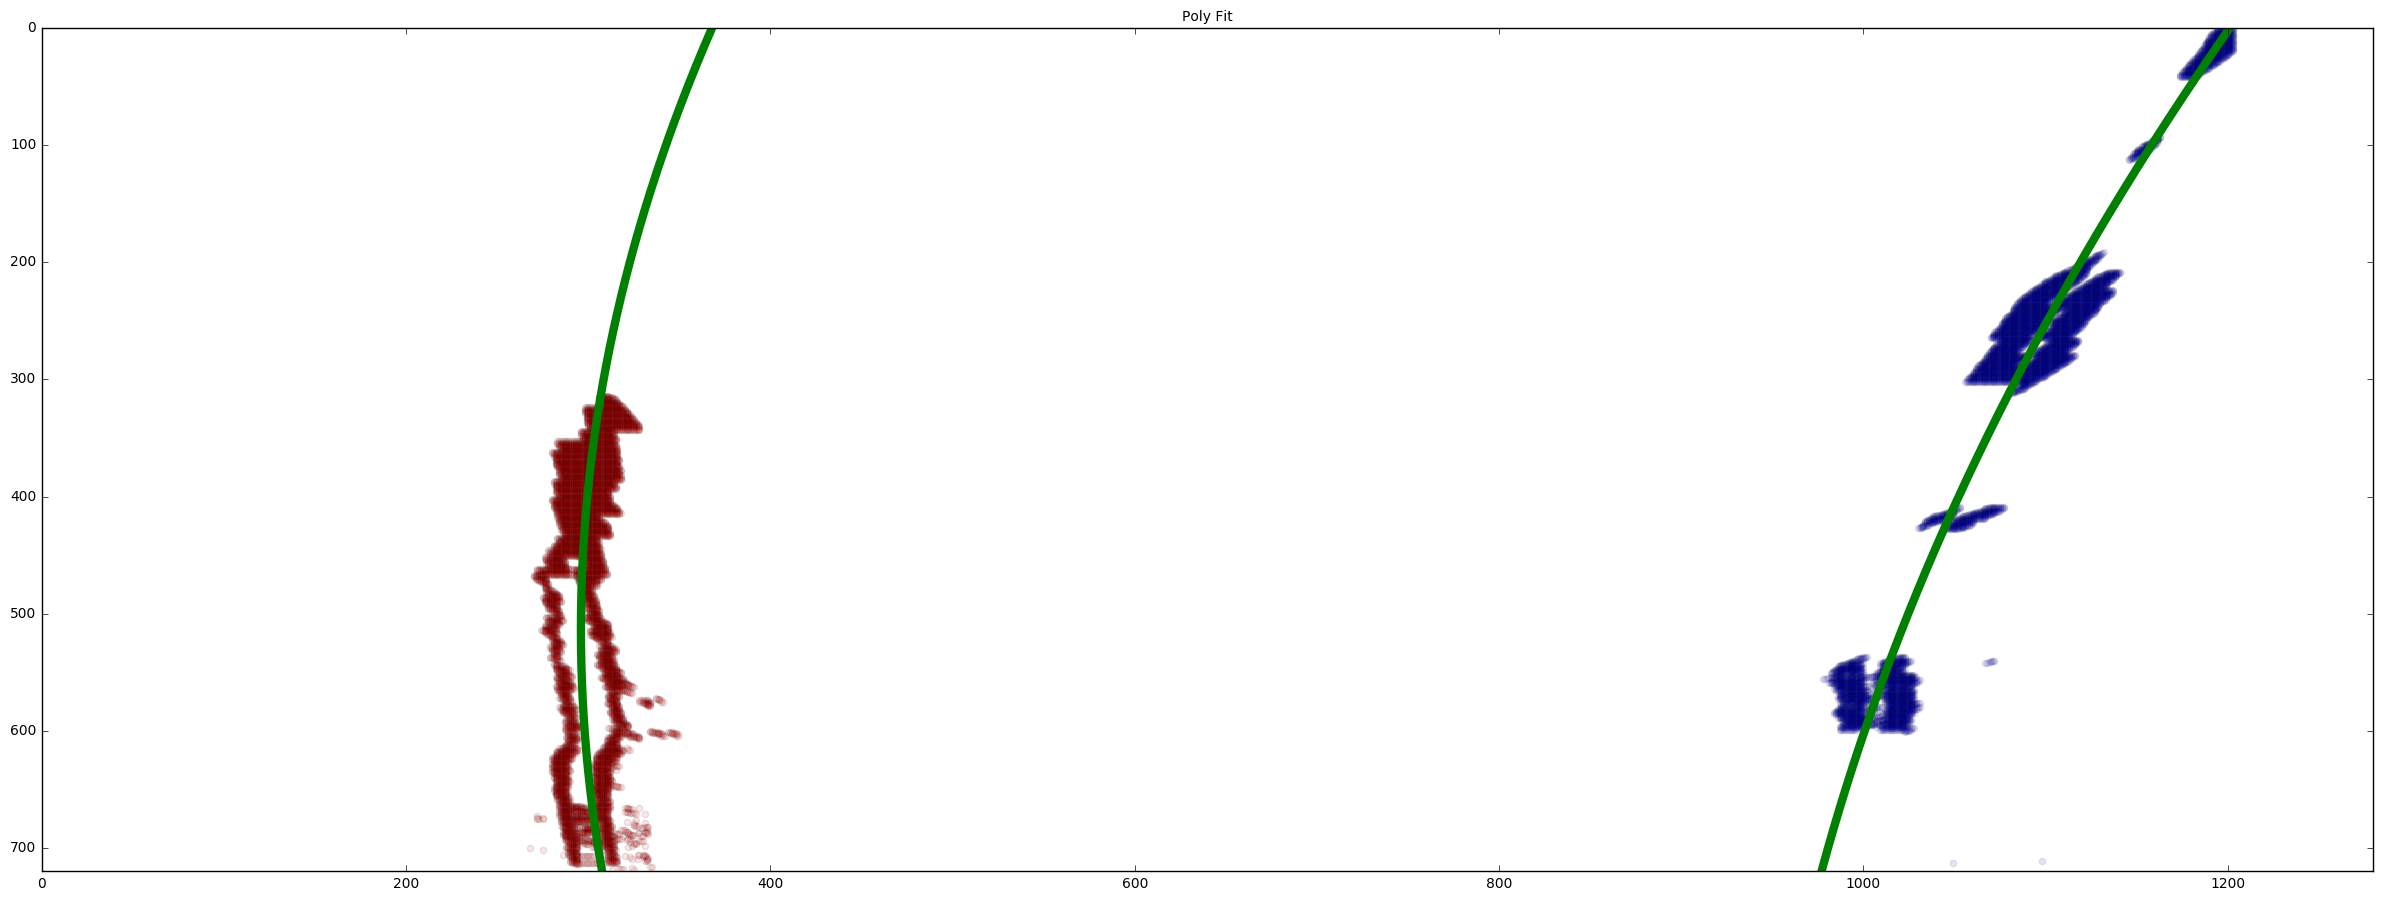

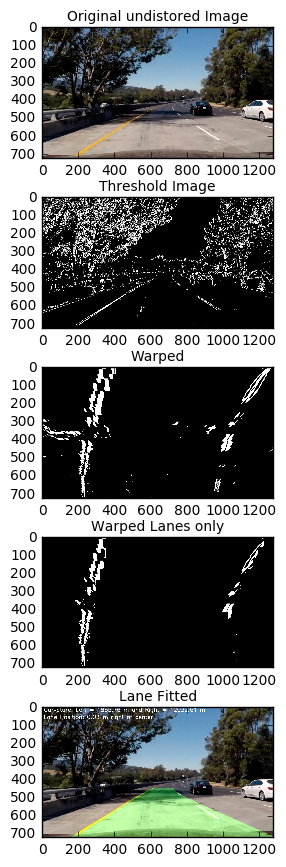

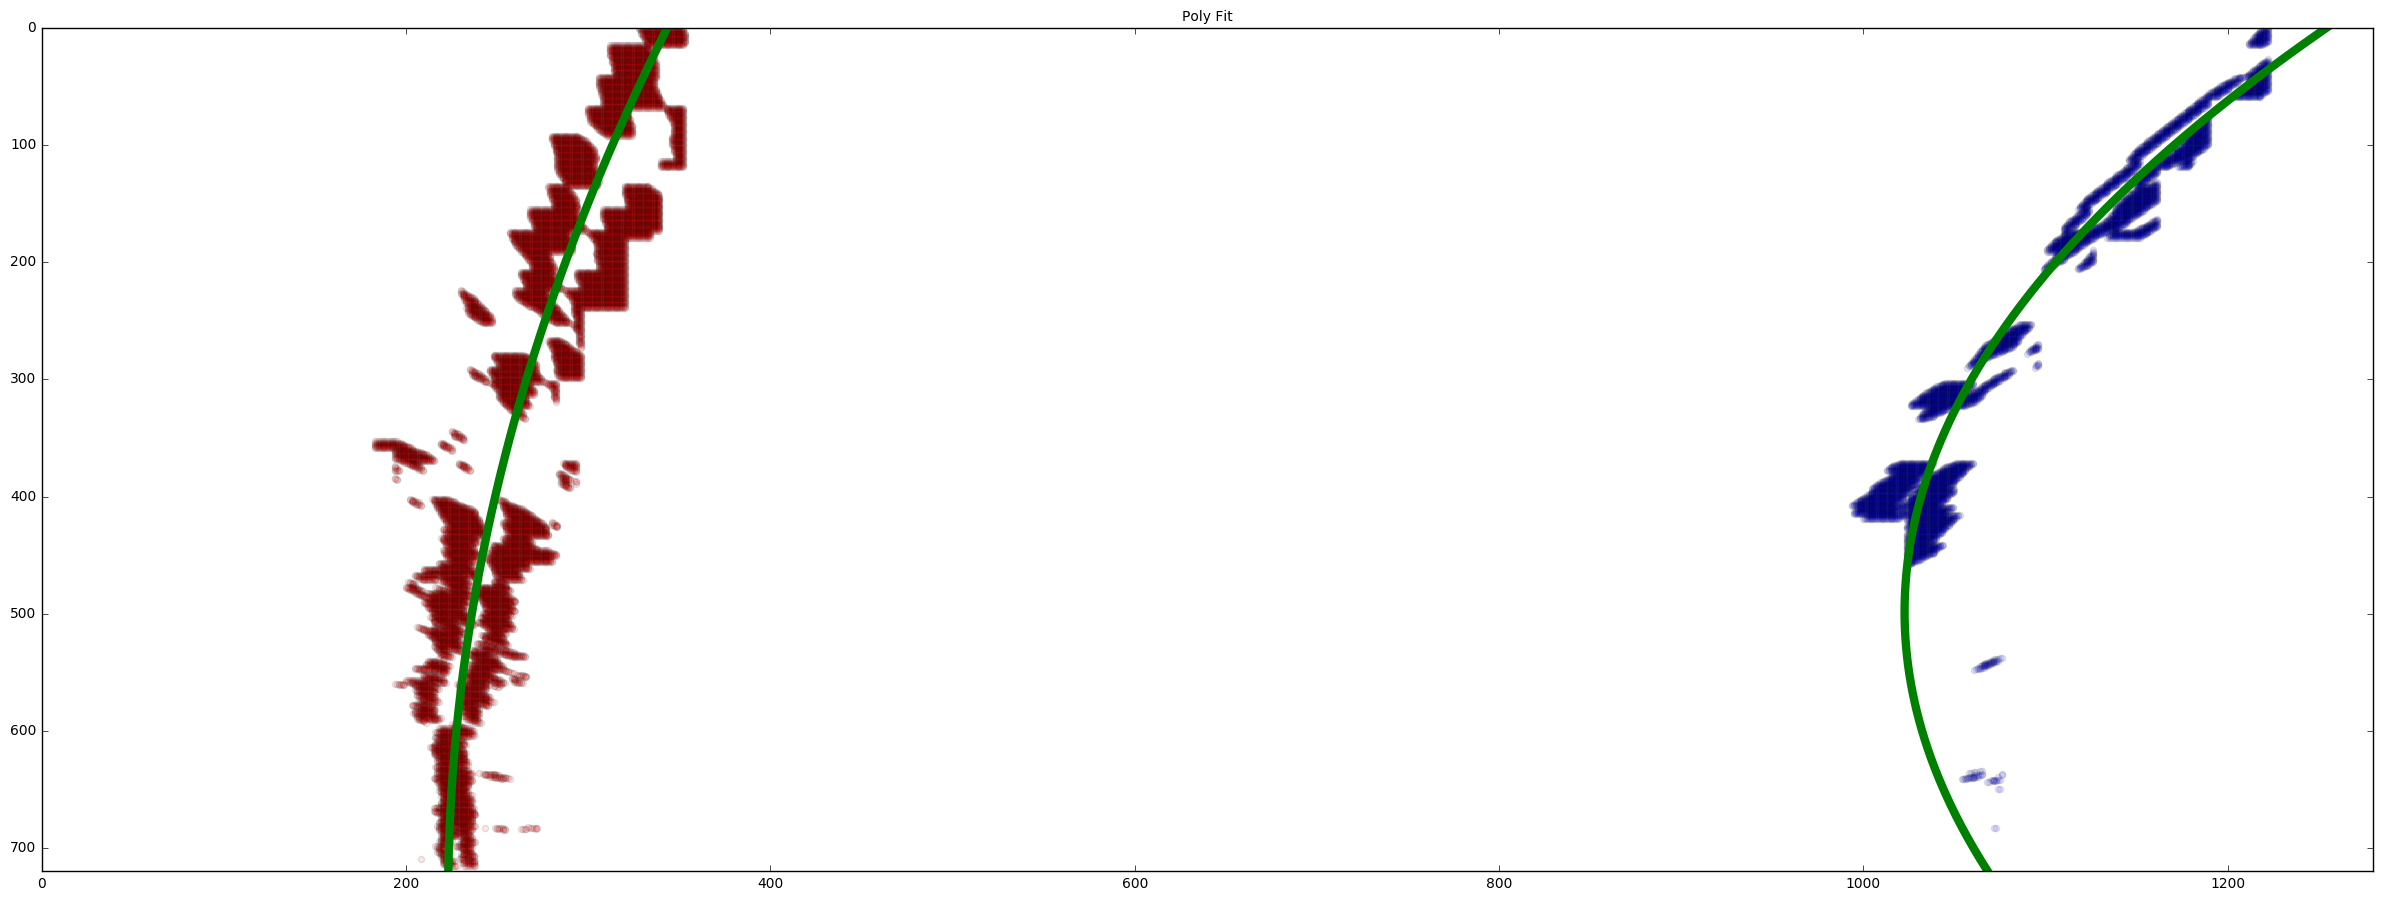

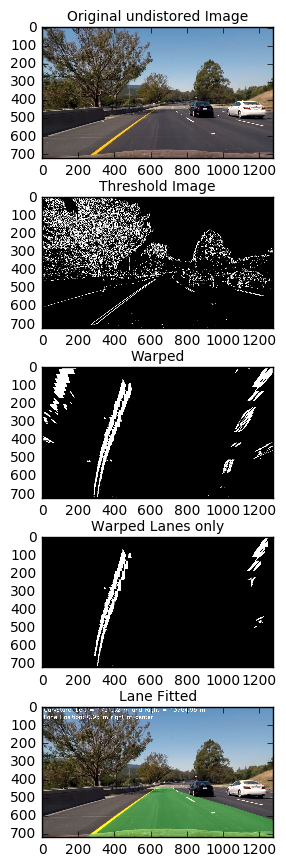

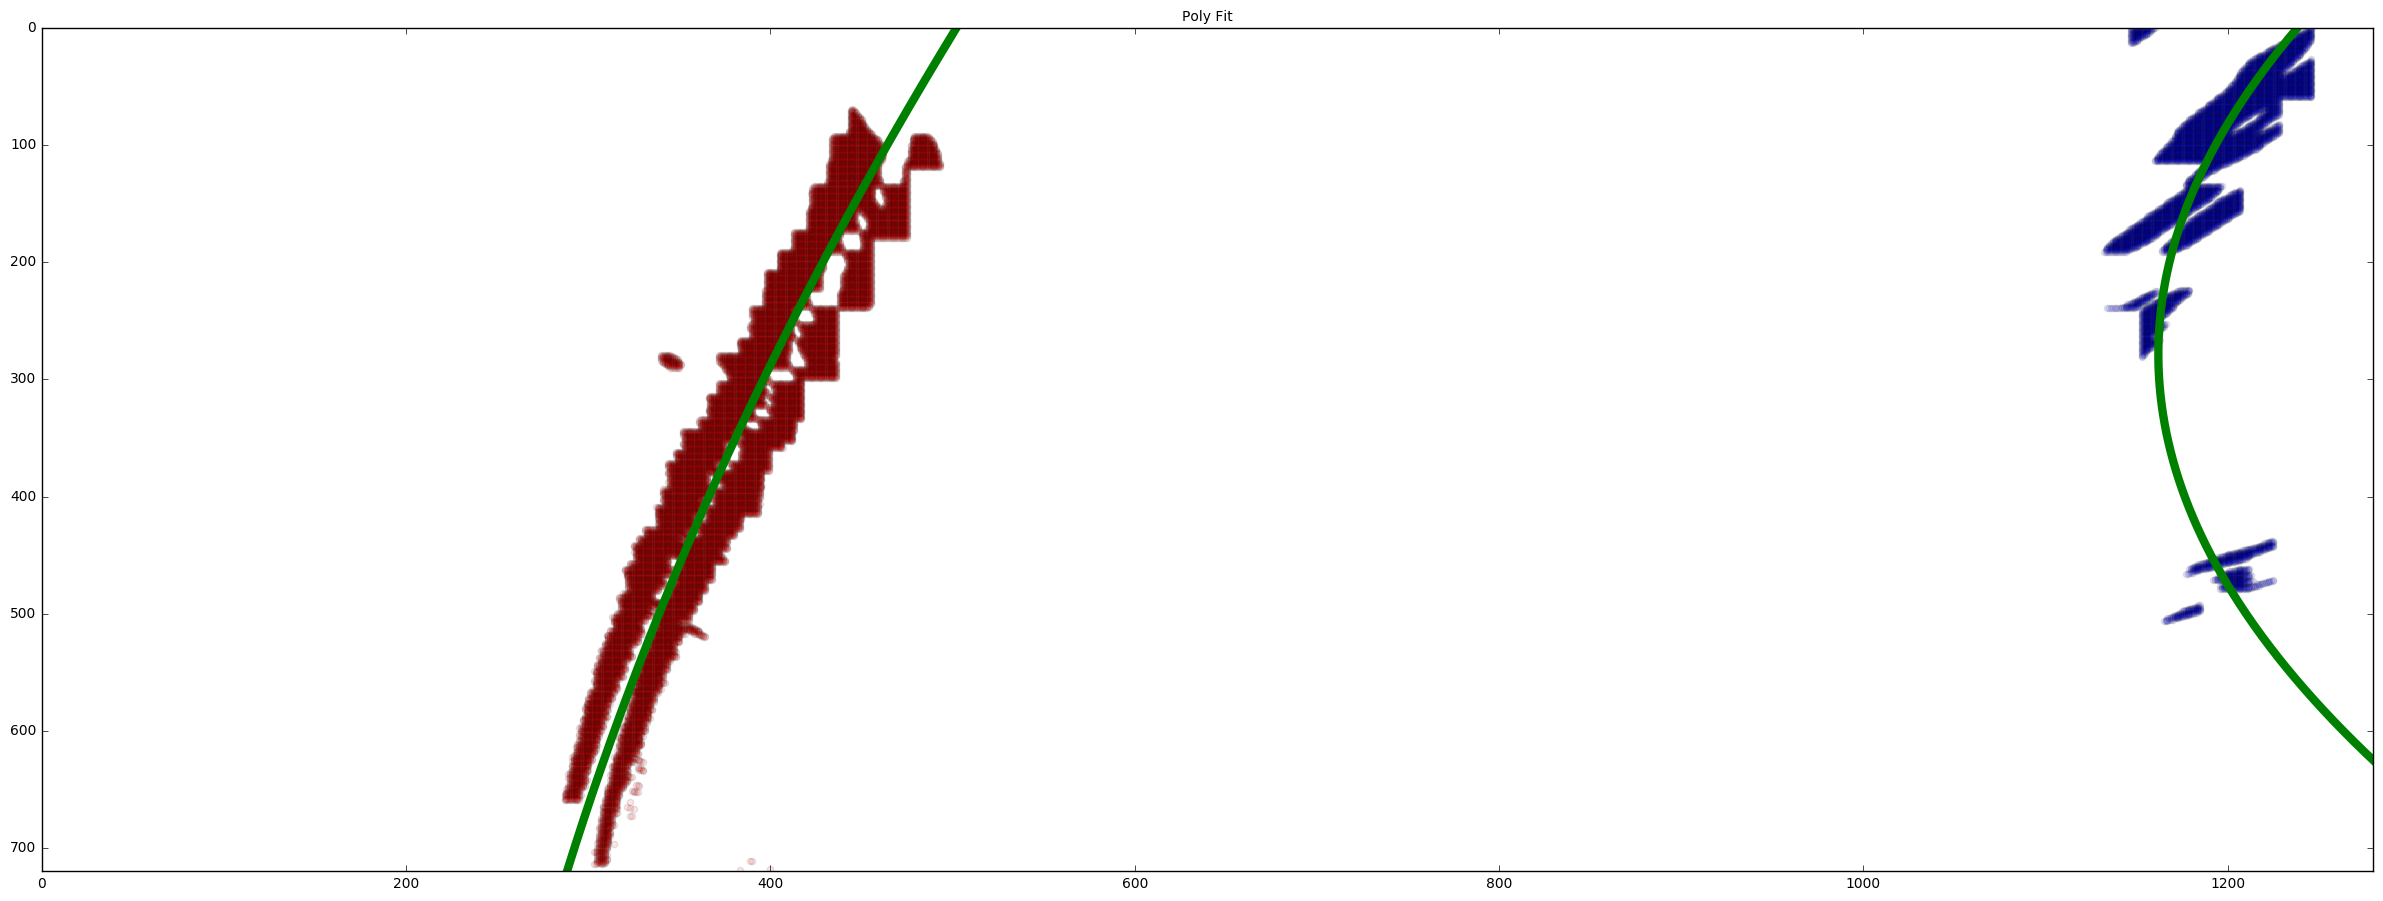

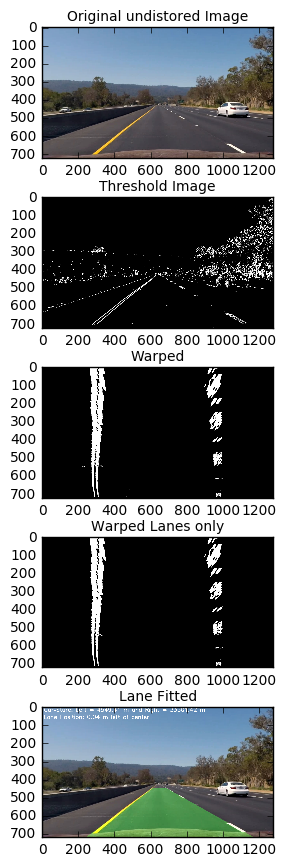

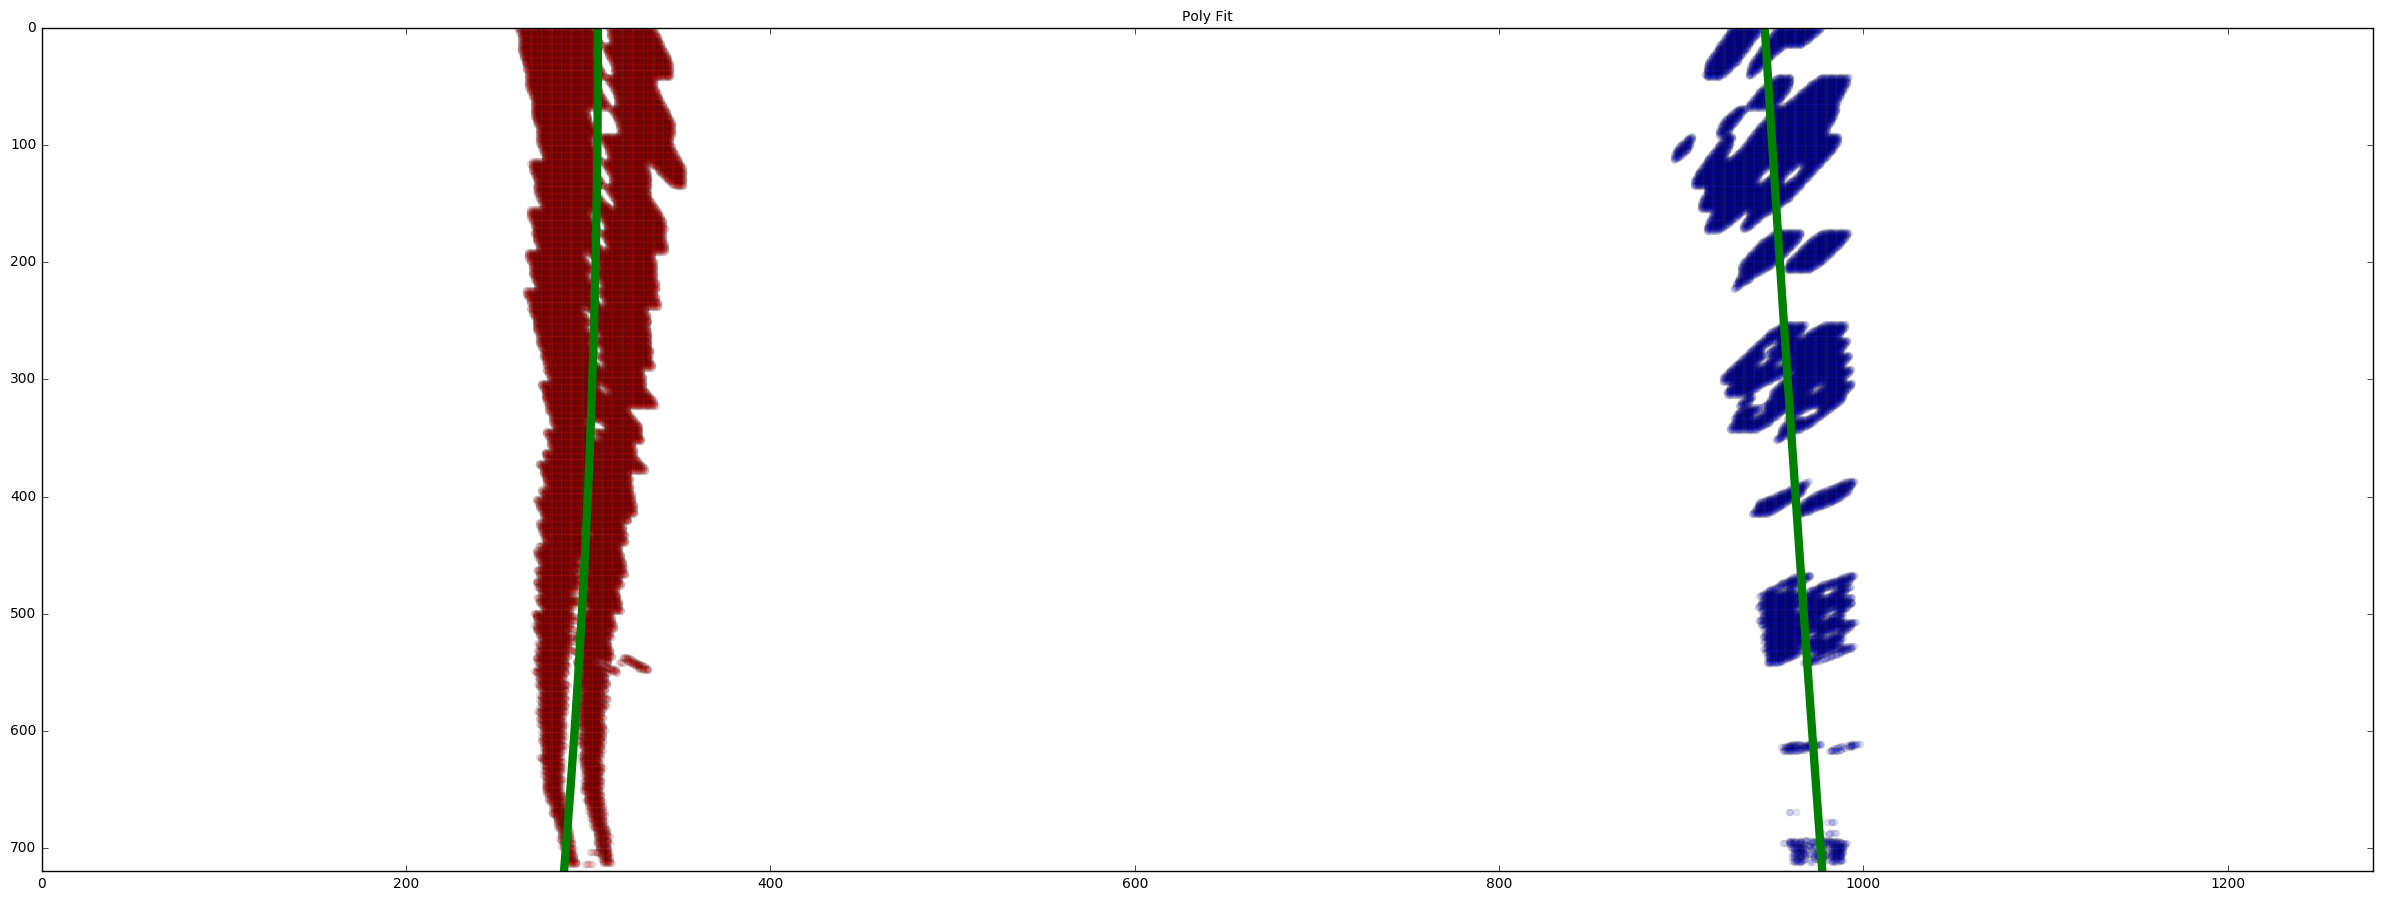

In [118]:
# Run pipeline on test images
%matplotlib inline

# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# read in saved M and Minv
M_pickle = pickle.load( open( "M_pickle.p", "rb" ) )
M = M_pickle["M"]
Minv = M_pickle["Minv"]


# Make a list of test images
images = glob.glob('test_images/test*.jpg')

left_line = Line()
right_line = Line()
bad_frames_cnt = 0

# Step through the list and undistort the images
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    fitted_img = pipeline(img, mtx, dist, M, Minv, left_line, right_line, plot_result=True, video_clip=False)
    mpimg.imsave('output_images/fitted_'+fname[12:],fitted_img)





### Now Try on Video with tracker of recent measurements and recovery capabilities

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [119]:
# two instances of Line to remember past history of line detection
# two global variable to hold past detection as I do not know how to pass additional paramters 
# in the function fl_image which can in turn be passed to process_image
left_line = Line()
right_line = Line()
bad_frames_cnt = 0

%matplotlib inline

# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# read in saved M and Minv
M_pickle = pickle.load( open( "M_pickle.p", "rb" ) )
M = M_pickle["M"]
Minv = M_pickle["Minv"]


def process_image(img):
    return pipeline(img, mtx, dist, M, Minv, left_line, right_line, plot_result=False, video_clip=True)

In [120]:

video1_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(video1_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:59<00:00,  7.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min


In [121]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video1_output))

In [95]:

video2_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
output_clip2 = clip2.fl_image(process_image)
%time output_clip2.write_videofile(video2_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:05<00:00,  7.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 6s


In [96]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video2_output))

In [97]:

video3_output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip('harder_challenge_video.mp4')
output_clip3 = clip3.fl_image(process_image)
%time output_clip3.write_videofile(video3_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [02:51<00:00,  6.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 2min 53s


In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video3_output))